### 1. Importation des bibliothèques nécessaires

### 2. Charger le jeu de données

### 3. Prétraitement des données



### 4. Construction de l'Autoencoder

Un autoencoder est un type de réseau de neurones qui apprend à compresser les données dans une représentation latente de taille réduite (appelé "code"), puis à les reconstruire à partir de ce code

### 5. Encoder les données

Après l'entraînement de l'autoencoder, nous utilisons uniquement la partie "encoder" du modèle pour obtenir les caractéristiques réduites.


### 6. Clustering sur les données encodées

Maintenant que les données ont été réduites à un espace de plus faible dimension, nous appliquons un algorithme de clustering comme K-Means.


### 7. Visualisation des clusters (optionnel)

Si tes données ont une faible dimension (par exemple, 2 ou 3 dimensions après encodage), tu peux visualiser les clusters.


### 8. Sauvegarde des résultats

### Résumé

Ce script :
1. Charge et normalise les données.
2. Utilise un autoencoder pour réduire la dimension des données.
3. Applique K-Means sur les données encodées pour identifier les clusters.
4. Visualise et sauvegarde les résultats.



### Améliorer Dernier Version 

In [7]:

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, models, optimizers, regularizers, losses
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import gc

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [8]:
# Charger les données à partir du fichier Parquet
df = pd.read_parquet('/app/data/full_df_output.parquet')

# Libérer la mémoire avant l'entraînement
gc.collect()


# Calcul du loyalty_score et du conversion_rate
df['loyalty_score'] = (
    (df['count_products_7m'] / (df['number_of_sessions_7m'] + 1)) * 0.5 +
    (df['total_purchase_value'] / (df['number_of_views_7m'] + 1)) * 0.5
)
df['conversion_rate'] = df['number_of_carts_7m'] / (df['number_of_sessions_7m'] + 1)

# Liste des variables pour le modèle
variables_acp = [
    'number_of_views_7m', 'number_of_carts_7m', 'number_of_sessions_7m', 
    'count_products_7m', 'loyalty_score', 'total_purchase_value', 'conversion_rate'
]
df = df[variables_acp]

# Normalisation des variables
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = df_scaled.astype('float32')

# Réduction de la dimensionnalité avec PCA avant d'entrainer le modèle
pca = PCA(n_components=5)  # Réduction à 5 composantes principales pour simplifier le problème
df_pca = pca.fit_transform(df_scaled)

Epoch 1/17
21166/21166 [==============================] - 159s 7ms/step - loss: 0.0405 - val_loss: 0.0267 - lr: 1.0728e-04
Epoch 2/17
21166/21166 [==============================] - 136s 6ms/step - loss: 0.0326 - val_loss: 0.0263 - lr: 1.0033e-04
Epoch 3/17
21166/21166 [==============================] - 128s 6ms/step - loss: 0.0320 - val_loss: 0.0261 - lr: 1.0000e-04
Epoch 4/17
21166/21166 [==============================] - 145s 7ms/step - loss: 0.0317 - val_loss: 0.0259 - lr: 1.0000e-04
Epoch 5/17
21166/21166 [==============================] - 141s 7ms/step - loss: 0.0315 - val_loss: 0.0260 - lr: 1.0000e-04
Epoch 6/17
21166/21166 [==============================] - 133s 6ms/step - loss: 0.0313 - val_loss: 0.0261 - lr: 1.0000e-04
Epoch 7/17
21166/21166 [==============================] - 101s 5ms/step - loss: 0.0311 - val_loss: 0.0261 - lr: 1.0000e-04
Epoch 8/17
21166/21166 [==============================] - 90s 4ms/step - loss: 0.0309 - val_loss: 0.0263 - lr: 1.0000e-04
Epoch 9/17
21166/

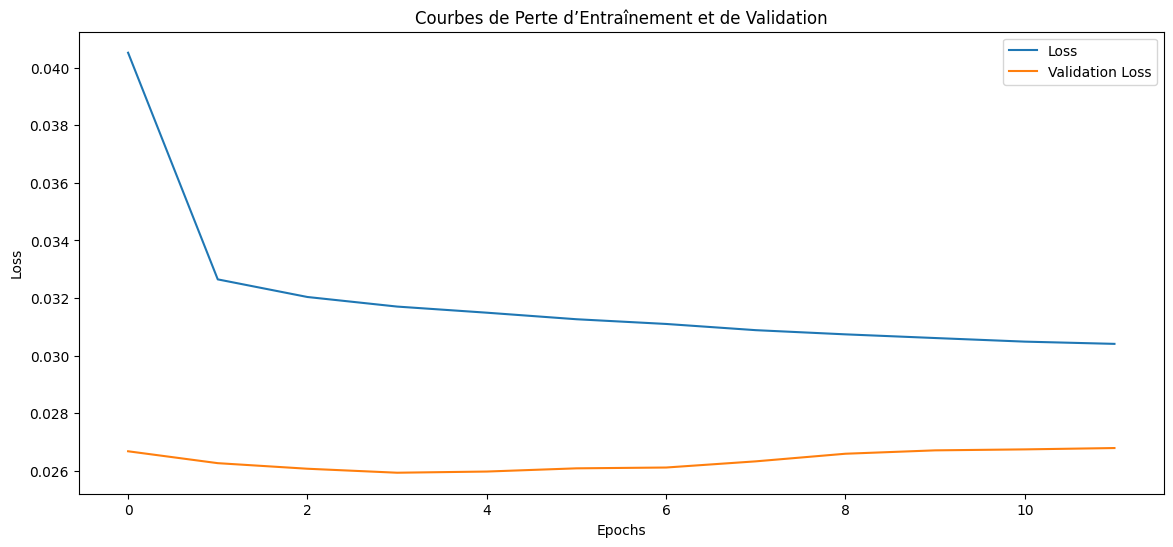

26457/26457 [==============================] - 91s 3ms/step


/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


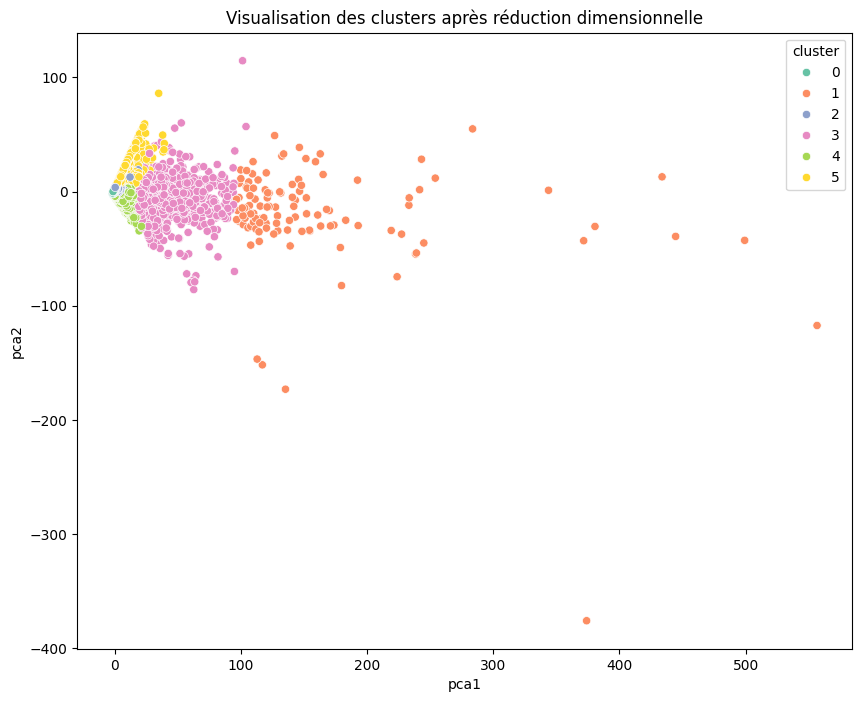

In [9]:


# Construction du modèle autoencodeur
input_layer = layers.Input(shape=(df_pca.shape[1],))
encoded = layers.Dense(16, activation='leaky_relu', activity_regularizer=regularizers.l2(1e-4))(input_layer)
encoded = layers.GaussianNoise(0.1)(encoded)  # Ajout de bruit pour introduire de la variabilité
encoded = layers.Dropout(0.5)(encoded)
encoded = layers.Dense(10, activation='leaky_relu')(encoded)
decoded = layers.Dense(16, activation='leaky_relu')(encoded)
decoded = layers.Dense(df_pca.shape[1], activation='sigmoid')(decoded)

# Modèle autoencodeur
autoencoder = models.Model(input_layer, decoded)

# Cyclical Learning Rate pour ajustement dynamique du taux d'apprentissage
initial_lr = 1e-4
lr_schedule = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=initial_lr,
    maximal_learning_rate=5e-4,
    scale_fn=lambda x: 1 / (2.0 ** (x - 1)),
    step_size=2000
)

# Compilation du modèle avec MSLE pour capturer les petites erreurs
autoencoder.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule), loss=losses.MeanSquaredLogarithmicError())

# Callbacks pour ajuster l'apprentissage et stopper tôt si nécessaire
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Entraînement du modèle
history = autoencoder.fit(
    df_pca, df_pca,
    epochs=17,  # Utiliser EarlyStopping pour ajuster dynamiquement
    batch_size=32, shuffle=True, validation_split=0.2,
    callbacks=[reduce_lr, early_stopping]
)

# Affichage des courbes de perte pour évaluer l'apprentissage
plt.figure(figsize=(14, 6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Courbes de Perte d’Entraînement et de Validation')
plt.show()

# Définir le modèle encodeur à partir de l'autoencodeur
encoder = models.Model(inputs=input_layer, outputs=encoded)

# Encoder les données pour obtenir les représentations latentes
encoded_data = encoder.predict(df_pca)

# Appliquer K-Means sur les représentations encodées pour le clustering
kmeans = KMeans(n_clusters=7, n_init=10)
clusters = kmeans.fit_predict(encoded_data)

# Réduction dimensionnelle avec PCA pour la visualisation
pca_result = PCA(n_components=2).fit_transform(encoded_data)

# Ajouter les résultats au DataFrame pour la visualisation des clusters
df['pca1'], df['pca2'] = pca_result[:, 0], pca_result[:, 1]
df['cluster'] = clusters

# Visualisation des clusters après réduction dimensionnelle
plt.figure(figsize=(10, 8))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df, palette='Set2', legend='full')
plt.title('Visualisation des clusters après réduction dimensionnelle')
plt.show()


In [10]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Calculer les métriques de segmentation
silhouette_avg = silhouette_score(encoded_data, clusters)
calinski_harabasz = calinski_harabasz_score(encoded_data, clusters)
davies_bouldin = davies_bouldin_score(encoded_data, clusters)

print(f"Silhouette Score: {silhouette_avg:.2f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.2f}")


KeyboardInterrupt: 

##  Interprétation des Résultats de Segmentation :
Silhouette Score : Plus proche de +1 est idéal, indiquant des clusters bien définis.

Calinski-Harabasz Index : Des valeurs plus élevées suggèrent une meilleure séparation.

Davies-Bouldin Index : Plus faible est meilleur, indiquant des clusters bien séparés